In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle

# Function to create lag features
def create_lag_features(df, lags=3):
    for col in df.columns:
        if col not in ['Datetime', 'City']:
            for lag in range(1, lags+1):
                df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df

# Preprocessing function
def preprocess_data(file_path, lags=3):
    df = pd.read_csv(file_path, parse_dates=['Datetime'])
    df = df.sort_values('Datetime')
    
    df = create_lag_features(df, lags)
    df = df.dropna()
    
    X = df.drop(columns=['Datetime', 'City'])
    y = df.drop(columns=['Datetime', 'City'])  # Predicting all pollutants
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    pickle.dump(scaler, open('scaler.pkl', 'wb'))  # Save scaler
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# Run preprocessing
if __name__ == "__main__":
    X_train, X_test, y_train, y_test = preprocess_data(r'C:\Users\ASUS\Desktop\Climate1\sorted_aqi_hourly_dataset.csv')
    print("Preprocessing completed.")


Preprocessing completed.


: 

d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


d:\Anacondaa\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


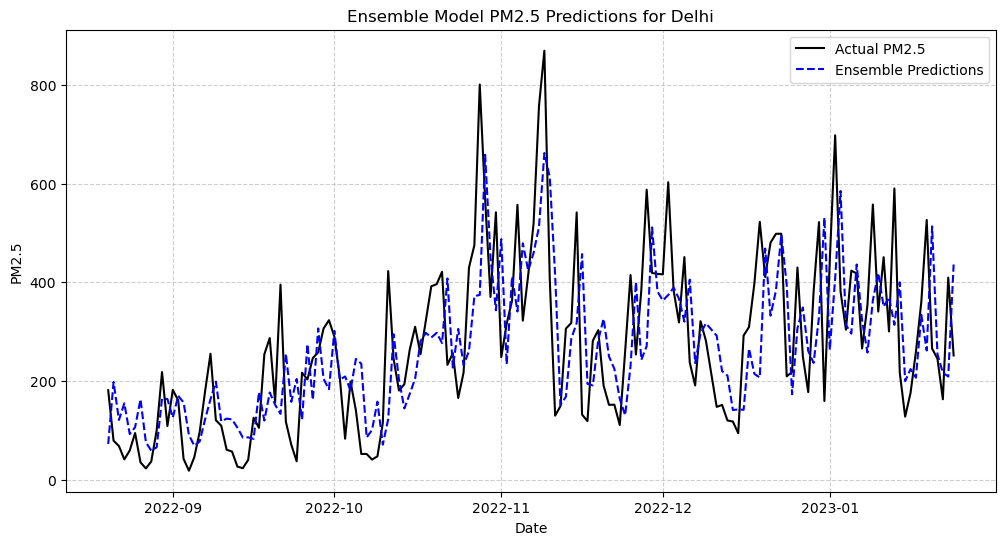

{'City': 'Delhi', 'Future Date': '2025-02-28', 'Predicted PM2.5': 436.21, 'MAE': 107.13, 'MSE': 18376.97, 'RMSE': 135.56, 'R2 Score': 0.37}


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
def load_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['Datetime'])
    df['date'] = pd.to_datetime(df['Datetime'].dt.date)
    return df

# Train XGBoost Model
def train_xgboost(X_train, y_train):
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)
    return model

# Train LSTM Model
def train_lstm(X_train, y_train):
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
    return model

# Train and predict using the ensemble model
def train_and_predict_ensemble(city, df, future_date):
    df_city = df[df['City'].str.lower() == city.lower()].copy()
    df_city = df_city.groupby('date')[['PM2.5']].mean().reset_index()
    df_city.set_index('date', inplace=True)
    
    # Feature Engineering (Lag Features)
    for lag in range(1, 8):
        df_city[f'lag_{lag}'] = df_city['PM2.5'].shift(lag)
    df_city.dropna(inplace=True)
    
    # Train-Test Split
    train_size = int(len(df_city) * 0.8)
    train, test = df_city.iloc[:train_size], df_city.iloc[train_size:]
    
    X_train, y_train = train.drop(columns=['PM2.5']), train['PM2.5']
    X_test, y_test = test.drop(columns=['PM2.5']), test['PM2.5']
    
    # Scale data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train models
    xgb_model = train_xgboost(X_train_scaled, y_train)
    lstm_model = train_lstm(X_train_scaled, y_train)
    
    # Predict on test data
    X_test_scaled_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
    xgb_preds = xgb_model.predict(X_test_scaled)
    lstm_preds = lstm_model.predict(X_test_scaled_reshaped).flatten()
    
    # Ensemble Prediction (Weighted Average)
    ensemble_preds = (xgb_preds * 0.6) + (lstm_preds * 0.4)
    
    # Future Prediction
    future_features = df_city.drop(columns=['PM2.5']).iloc[-1:].values
    future_scaled = scaler.transform(future_features)
    future_scaled_reshaped = future_scaled.reshape((future_scaled.shape[0], future_scaled.shape[1], 1))
    
    xgb_future_pred = xgb_model.predict(future_scaled)[0]
    lstm_future_pred = lstm_model.predict(future_scaled_reshaped)[0][0]
    future_pred = (xgb_future_pred * 0.6) + (lstm_future_pred * 0.4)
    
    # Compute error metrics
    mae = mean_absolute_error(y_test, ensemble_preds)
    mse = mean_squared_error(y_test, ensemble_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, ensemble_preds)
    
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, y_test, label='Actual PM2.5', color='black')
    plt.plot(test.index, ensemble_preds, label='Ensemble Predictions', linestyle='dashed', color='blue')
    plt.legend()
    plt.title(f'Ensemble Model PM2.5 Predictions for {city}')
    plt.xlabel('Date')
    plt.ylabel('PM2.5')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    
    return {
        "City": city,
        "Future Date": future_date,
        "Predicted PM2.5": round(future_pred, 2),
        "MAE": round(mae, 2),
        "MSE": round(mse, 2),
        "RMSE": round(rmse, 2),
        "R2 Score": round(r2, 2)
    }

# Example usage
if __name__ == "__main__":
    file_path = r'C:\Users\ASUS\Desktop\Climate1\sorted_aqi_hourly_dataset.csv'
    df = load_data(file_path)
    city = input("Enter city name: ")
    future_date = input("Enter future date (YYYY-MM-DD): ")
    result = train_and_predict_ensemble(city, df, future_date)
    print(result)


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


d:\Anacondaa\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


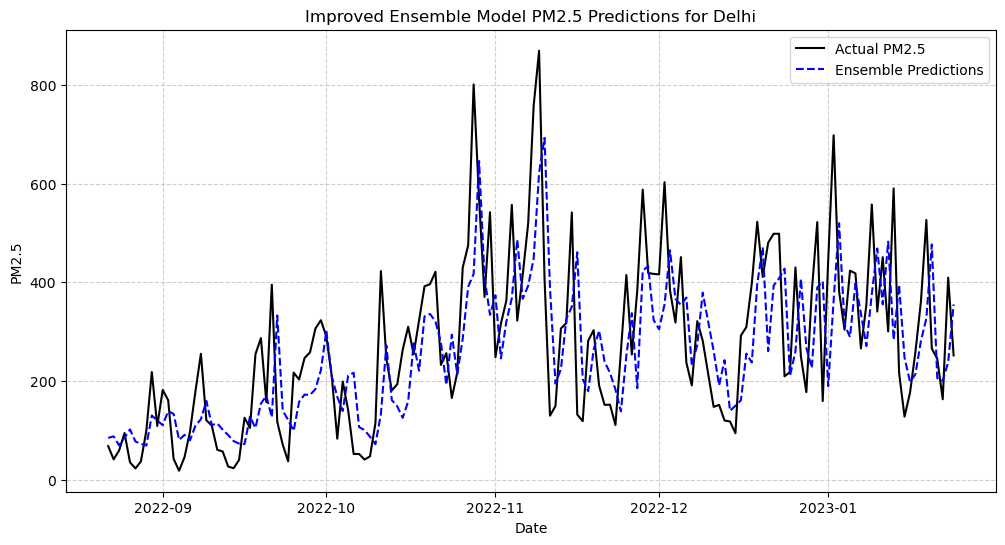

{'City': 'Delhi', 'Future Date': '2025-02-28', 'Predicted PM2.5': 355.29, 'MAE': 102.98, 'MSE': 16727.8, 'RMSE': 129.34, 'R2 Score': 0.43}


In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
def load_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['Datetime'])
    df['date'] = pd.to_datetime(df['Datetime'].dt.date)
    return df

# Train XGBoost Model
def train_xgboost(X_train, y_train):
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, max_depth=7, learning_rate=0.05)
    model.fit(X_train, y_train)
    return model

# Train LSTM Model
def train_lstm(X_train, y_train):
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
    return model

# Train and predict using the ensemble model
def train_and_predict_ensemble(city, df, future_date):
    df_city = df[df['City'].str.lower() == city.lower()].copy()
    df_city = df_city.groupby('date')[['PM2.5']].mean().reset_index()
    df_city.set_index('date', inplace=True)
    
    # Feature Engineering (Lag Features)
    for lag in range(1, 15):  # Increased lag features
        df_city[f'lag_{lag}'] = df_city['PM2.5'].shift(lag)
    df_city.dropna(inplace=True)
    
    # Train-Test Split
    train_size = int(len(df_city) * 0.8)
    train, test = df_city.iloc[:train_size], df_city.iloc[train_size:]
    
    X_train, y_train = train.drop(columns=['PM2.5']), train['PM2.5']
    X_test, y_test = test.drop(columns=['PM2.5']), test['PM2.5']
    
    # Scale data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train models
    xgb_model = train_xgboost(X_train_scaled, y_train)
    lstm_model = train_lstm(X_train_scaled, y_train)
    
    # Predict on test data
    X_test_scaled_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
    xgb_preds = xgb_model.predict(X_test_scaled)
    lstm_preds = lstm_model.predict(X_test_scaled_reshaped).flatten()
    
    # Ensemble Prediction (Weighted Average)
    ensemble_preds = (xgb_preds * 0.5) + (lstm_preds * 0.5)  # Balanced weights
    
    # Future Prediction
    future_features = df_city.drop(columns=['PM2.5']).iloc[-1:].values
    future_scaled = scaler.transform(future_features)
    future_scaled_reshaped = future_scaled.reshape((future_scaled.shape[0], future_scaled.shape[1], 1))
    
    xgb_future_pred = xgb_model.predict(future_scaled)[0]
    lstm_future_pred = lstm_model.predict(future_scaled_reshaped)[0][0]
    future_pred = (xgb_future_pred * 0.5) + (lstm_future_pred * 0.5)
    
    # Compute error metrics
    mae = mean_absolute_error(y_test, ensemble_preds)
    mse = mean_squared_error(y_test, ensemble_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, ensemble_preds)
    
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, y_test, label='Actual PM2.5', color='black')
    plt.plot(test.index, ensemble_preds, label='Ensemble Predictions', linestyle='dashed', color='blue')
    plt.legend()
    plt.title(f'Improved Ensemble Model PM2.5 Predictions for {city}')
    plt.xlabel('Date')
    plt.ylabel('PM2.5')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    
    return {
        "City": city,
        "Future Date": future_date,
        "Predicted PM2.5": round(future_pred, 2),
        "MAE": round(mae, 2),
        "MSE": round(mse, 2),
        "RMSE": round(rmse, 2),
        "R2 Score": round(r2, 2)
    }

# Example usage
if __name__ == "__main__":
    file_path = r'C:\Users\ASUS\Desktop\Climate1\sorted_aqi_hourly_dataset.csv'
    df = load_data(file_path)
    city = input("Enter city name: ")
    future_date = input("Enter future date (YYYY-MM-DD): ")
    result = train_and_predict_ensemble(city, df, future_date)
    print(result)


In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
def load_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['Datetime'])
    df['date'] = pd.to_datetime(df['Datetime'].dt.date)
    return df

# Train XGBoost Model
def train_xgboost(X_train, y_train, X_val, y_val):
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        max_depth=6,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=20, verbose=False)
    return model

# Train LSTM Model
def train_lstm(X_train, y_train, X_val, y_val):
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
    
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.3),
        LSTM(50, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=32, verbose=0)
    return model

# Train and predict using the ensemble model
def train_and_predict_ensemble(city, df, future_date):
    df_city = df[df['City'].str.lower() == city.lower()].copy()
    df_city = df_city.groupby('date')[['PM2.5']].mean().reset_index()
    df_city.set_index('date', inplace=True)
    
    # Feature Engineering (Lag Features)
    for lag in range(1, 8):  # Reduce lags to prevent overfitting
        df_city[f'lag_{lag}'] = df_city['PM2.5'].shift(lag)
    df_city.dropna(inplace=True)
    
    # Train-Test-Validation Split
    train_size = int(len(df_city) * 0.7)
    val_size = int(len(df_city) * 0.1)
    train, val, test = (
        df_city.iloc[:train_size],
        df_city.iloc[train_size:train_size + val_size],
        df_city.iloc[train_size + val_size:]
    )
    
    X_train, y_train = train.drop(columns=['PM2.5']), train['PM2.5']
    X_val, y_val = val.drop(columns=['PM2.5']), val['PM2.5']
    X_test, y_test = test.drop(columns=['PM2.5']), test['PM2.5']
    
    # Scale data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Train models
    xgb_model = train_xgboost(X_train_scaled, y_train, X_val_scaled, y_val)
    lstm_model = train_lstm(X_train_scaled, y_train, X_val_scaled, y_val)
    
    # Predict on test data
    X_test_scaled_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
    xgb_preds = xgb_model.predict(X_test_scaled)
    lstm_preds = lstm_model.predict(X_test_scaled_reshaped).flatten()
    
    # Ensemble Prediction (Balanced Weighting)
    ensemble_preds = (xgb_preds * 0.5) + (lstm_preds * 0.5)
    
    # Future Prediction
    future_features = df_city.drop(columns=['PM2.5']).iloc[-1:].values
    future_scaled = scaler.transform(future_features)
    future_scaled_reshaped = future_scaled.reshape((future_scaled.shape[0], future_scaled.shape[1], 1))
    
    xgb_future_pred = xgb_model.predict(future_scaled)[0]
    lstm_future_pred = lstm_model.predict(future_scaled_reshaped)[0][0]
    future_pred = (xgb_future_pred * 0.5) + (lstm_future_pred * 0.5)
    
    # Compute error metrics
    mae = mean_absolute_error(y_test, ensemble_preds)
    mse = mean_squared_error(y_test, ensemble_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, ensemble_preds)
    
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, y_test, label='Actual PM2.5', color='black')
    plt.plot(test.index, ensemble_preds, label='Ensemble Predictions', linestyle='dashed', color='blue')
    plt.legend()
    plt.title(f'Improved Ensemble Model PM2.5 Predictions for {city}')
    plt.xlabel('Date')
    plt.ylabel('PM2.5')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    
    return {
        "City": city,
        "Future Date": future_date,
        "Predicted PM2.5": round(future_pred, 2),
        "MAE": round(mae, 2),
        "MSE": round(mse, 2),
        "RMSE": round(rmse, 2),
        "R2 Score": round(r2, 2)
    }

# Example usage
if __name__ == "__main__":
    file_path = r'C:\Users\ASUS\Desktop\Climate1\delhi_aqi.csv'

    df = load_data(file_path)
    city = input("Enter city name: ")
    future_date = input("Enter future date (YYYY-MM-DD): ")
    result = train_and_predict_ensemble(city, df, future_date)
    print(result)


ValueError: Missing column provided to 'parse_dates': 'Datetime'

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
def load_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['date'])
    df['date'] = pd.to_datetime(df[''].dt.date)
    return df

# Train XGBoost Model
def train_xgboost(X_train, y_train, X_val, y_val):
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=300,
        max_depth=8,
        learning_rate=0.02,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=25, verbose=False)
    return model

# Train LSTM Model
def train_lstm(X_train, y_train, X_val, y_val):
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
    
    model = Sequential([
        LSTM(150, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.3),
        LSTM(100, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32, verbose=0)
    return model

# Train and predict using the ensemble model
def train_and_predict_ensemble(df, future_date):
    df = df.groupby('date')[['PM2.5']].mean().reset_index()
    df.set_index('date', inplace=True)
    
    # Feature Engineering (Lag Features)
    for lag in range(1, 15):  # Increased lag range
        df[f'lag_{lag}'] = df['PM2.5'].shift(lag)
    df.dropna(inplace=True)
    
    # Train-Test-Validation Split
    train_size = int(len(df) * 0.7)
    val_size = int(len(df) * 0.15)
    train, val, test = (
        df.iloc[:train_size],
        df.iloc[train_size:train_size + val_size],
        df.iloc[train_size + val_size:]
    )
    
    X_train, y_train = train.drop(columns=['PM2.5']), train['PM2.5']
    X_val, y_val = val.drop(columns=['PM2.5']), val['PM2.5']
    X_test, y_test = test.drop(columns=['PM2.5']), test['PM2.5']
    
    # Scale data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Train models
    xgb_model = train_xgboost(X_train_scaled, y_train, X_val_scaled, y_val)
    lstm_model = train_lstm(X_train_scaled, y_train, X_val_scaled, y_val)
    
    # Predict on test data
    X_test_scaled_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
    xgb_preds = xgb_model.predict(X_test_scaled)
    lstm_preds = lstm_model.predict(X_test_scaled_reshaped).flatten()
    
    # Ensemble Prediction (Balanced Weighting)
    ensemble_preds = (xgb_preds * 0.5) + (lstm_preds * 0.5)
    
    # Future Prediction
    future_features = df.drop(columns=['PM2.5']).iloc[-1:].values
    future_scaled = scaler.transform(future_features)
    future_scaled_reshaped = future_scaled.reshape((future_scaled.shape[0], future_scaled.shape[1], 1))
    
    xgb_future_pred = xgb_model.predict(future_scaled)[0]
    lstm_future_pred = lstm_model.predict(future_scaled_reshaped)[0][0]
    future_pred = (xgb_future_pred * 0.5) + (lstm_future_pred * 0.5)
    
    # Compute error metrics
    mae = mean_absolute_error(y_test, ensemble_preds)
    mse = mean_squared_error(y_test, ensemble_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, ensemble_preds)
    
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, y_test, label='Actual PM2.5', color='black')
    plt.plot(test.index, ensemble_preds, label='Ensemble Predictions', linestyle='dashed', color='blue')
    plt.legend()
    plt.title(f'Enhanced Ensemble Model PM2.5 Predictions')
    plt.xlabel('Date')
    plt.ylabel('PM2.5')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    
    return {
        "Future Date": future_date,
        "Predicted PM2.5": round(future_pred, 2),
        "MAE": round(mae, 2),
        "MSE": round(mse, 2),
        "RMSE": round(rmse, 2),
        "R2 Score": round(r2, 2)
    }

# Example usage
if __name__ == "__main__":
    file_path = r'C:\Users\ASUS\Desktop\Climate1\delhi_aqi.csv'

    df = load_data(file_path)
    future_date = input("Enter future date (YYYY-MM-DD): ")
    result = train_and_predict_ensemble(df, future_date)
    print(result)

KeyError: "Columns not found: 'PM2.5'"

In [12]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load and preprocess dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df['hour'] = df['date'].dt.hour
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df.drop(columns=['date'], inplace=True)
    return df

# Define file path
file_path = r'C:\Users\ASUS\Desktop\Climate1\delhi_aqi.csv'
df = load_data(file_path)

# Define features and target
features = ['co', 'no', 'no2', 'o3', 'so2', 'pm10', 'nh3', 'hour', 'day', 'month', 'year']
target = 'pm2_5'

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, shuffle=False)

# Normalize features for LSTM
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Train LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, 11)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=1)
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# Ensemble model (weighted average of XGBoost and LSTM predictions)
def ensemble_predictions(y_xgb, y_lstm, weight_xgb=0.5, weight_lstm=0.5):
    return (weight_xgb * y_xgb) + (weight_lstm * y_lstm)

# Get final ensemble predictions
y_pred_ensemble = ensemble_predictions(y_pred_xgb, y_pred_lstm, weight_xgb=0.5, weight_lstm=0.5)

# Evaluate models
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
lstm_mse = mean_squared_error(y_test, y_pred_lstm)
ensemble_mse = mean_squared_error(y_test, y_pred_ensemble)
print(y_pred_ensemble)

print(f"XGBoost MSE: {xgb_mse}")
print(f"LSTM MSE: {lstm_mse}")
print(f"Ensemble Model MSE: {ensemble_mse}")


Epoch 1/20


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


470/470 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 82207.2891 - val_loss: 48918.5820
Epoch 2/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 29231.4473 - val_loss: 11169.4453
Epoch 3/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8479.7305 - val_loss: 5169.2720
Epoch 4/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3849.9026 - val_loss: 3421.2092
Epoch 5/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2736.3770 - val_loss: 1800.0588
Epoch 6/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2268.4138 - val_loss: 2119.0303
Epoch 7/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1961.8765 - val_loss: 2287.5667
Epoch 8/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1815.7672 - val_loss: 1734.5754
Epoch 9/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1592.3278 - val_loss: 1655.8275
Epoch 10/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1485.8729 - val_loss: 1373.8474
Epoch 11/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1491.2201 - val_loss: 970

In [13]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib
import pickle

# Load and preprocess dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df['hour'] = df['date'].dt.hour
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df.drop(columns=['date'], inplace=True)
    return df

# Define file path
file_path = r'C:\Users\ASUS\Desktop\Climate1\delhi_aqi.csv'
df = load_data(file_path)

# Define features and target
features = ['co', 'no', 'no2', 'o3', 'so2', 'pm10', 'nh3', 'hour', 'day', 'month', 'year']
target = 'pm2_5'

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, shuffle=False)

# Normalize features for LSTM
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Train LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, 11)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=1)
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# Ensemble model (weighted average of XGBoost and LSTM predictions)
def ensemble_predictions(y_xgb, y_lstm, weight_xgb=0.5, weight_lstm=0.5):
    return (weight_xgb * y_xgb) + (weight_lstm * y_lstm)

# Get final ensemble predictions
y_pred_ensemble = ensemble_predictions(y_pred_xgb, y_pred_lstm, weight_xgb=0.5, weight_lstm=0.5)

# Evaluate models
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
lstm_mse = mean_squared_error(y_test, y_pred_lstm)
ensemble_mse = mean_squared_error(y_test, y_pred_ensemble)
print(y_pred_ensemble)

print(f"XGBoost MSE: {xgb_mse}")
print(f"LSTM MSE: {lstm_mse}")
print(f"Ensemble Model MSE: {ensemble_mse}")

# Save the models
xgb_model.save_model("xgb_model.json")
lstm_model.save("lstm_model.h5")
joblib.dump(scaler, "scaler.pkl")

# Save ensemble model
ensemble_model_data = {
    "xgb_model": "xgb_model.json",
    "lstm_model": "lstm_model.h5",
    "scaler": "scaler.pkl",
    "weights": (0.5, 0.5)
}
with open("ensemble_model.pkl", "wb") as f:
    pickle.dump(ensemble_model_data, f)

# Function to load the models
def load_models():
    xgb_loaded = xgb.XGBRegressor()
    xgb_loaded.load_model("xgb_model.json")
    lstm_loaded = load_model("lstm_model.h5")
    scaler_loaded = joblib.load("scaler.pkl")
    return xgb_loaded, lstm_loaded, scaler_loaded


Epoch 1/20


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


470/470 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 93134.1406 - val_loss: 56417.7422
Epoch 2/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 41991.9922 - val_loss: 17737.4922
Epoch 3/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10768.0596 - val_loss: 6697.3774
Epoch 4/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5592.3457 - val_loss: 3407.2371
Epoch 5/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3375.8442 - val_loss: 2630.9822
Epoch 6/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2760.1025 - val_loss: 2018.6783
Epoch 7/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2026.2686 - val_loss: 2303.7466
Epoch 8/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1858.0758 - val_loss: 1381.6644
Epoch 9/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1685.3774 - val_loss: 1177.8572
Epoch 10/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1625.4595 - val_loss: 1697.7317
Epoch 11/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1413.0546 - val_loss: 75

[ 44.483864  44.817833  47.16088  ... 255.91412  172.78384  133.05252 ]
XGBoost MSE: 310.66211173708007
LSTM MSE: 526.5566694359912
Ensemble Model MSE: 264.6360913444236


In [15]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib
import pickle

# Load and preprocess dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df['hour'] = df['date'].dt.hour
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df.drop(columns=['date'], inplace=True)
    return df

# Define file path
file_path = r'C:\Users\ASUS\Desktop\Climate1\delhi_aqi.csv'
df = load_data(file_path)

# Define features and target
features = ['co', 'no', 'no2', 'o3', 'so2', 'pm10', 'nh3', 'hour', 'day', 'month', 'year']
target = 'pm2_5'

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, shuffle=False)

# Normalize features for LSTM
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Train LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, 11)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=1)
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# Ensemble model (weighted average of XGBoost and LSTM predictions)
def ensemble_predictions(y_xgb, y_lstm, weight_xgb=0.5, weight_lstm=0.5):
    return (weight_xgb * y_xgb) + (weight_lstm * y_lstm)

# Get final ensemble predictions
y_pred_ensemble = ensemble_predictions(y_pred_xgb, y_pred_lstm, weight_xgb=0.5, weight_lstm=0.5)

# Evaluate models
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
lstm_mse = mean_squared_error(y_test, y_pred_lstm)
ensemble_mse = mean_squared_error(y_test, y_pred_ensemble)
print(y_pred_ensemble)

print(f"XGBoost MSE: {xgb_mse}")
print(f"LSTM MSE: {lstm_mse}")
print(f"Ensemble Model MSE: {ensemble_mse}")

# Save the models
xgb_model.save_model("xgb_model.json")
lstm_model.save("lstm_model.h5")
joblib.dump(scaler, "scaler.pkl")

# Save ensemble model
ensemble_model_data = {
    "xgb_model": "xgb_model.json",
    "lstm_model": "lstm_model.h5",
    "scaler": "scaler.pkl",
    "weights": (0.5, 0.5)
}
with open("ensemble_model2.pkl", "wb") as f:
    pickle.dump(ensemble_model_data, f)

# Function to load the models
def load_models():
    with open("ensemble_model2.pkl", "rb") as f:
        ensemble_data = pickle.load(f)
    
    xgb_loaded = xgb.XGBRegressor()
    xgb_loaded.load_model(ensemble_data["xgb_model"])
    lstm_loaded = load_model(ensemble_data["lstm_model"])
    scaler_loaded = joblib.load(ensemble_data["scaler"])
    weights = ensemble_data["weights"]
    
    return xgb_loaded, lstm_loaded, scaler_loaded, weights

# Function to predict AQI for a specific input
def predict_aqi(input_data):
    xgb_model, lstm_model, scaler, weights = load_models()
    
    # Preprocess input
    input_scaled = scaler.transform([input_data])
    input_lstm = input_scaled.reshape((1, 1, len(input_data)))
    
    # Make predictions
    pred_xgb = xgb_model.predict(input_scaled)[0]
    pred_lstm = lstm_model.predict(input_lstm)[0][0]
    
    # Ensemble prediction
    pred_ensemble = ensemble_predictions(pred_xgb, pred_lstm, weight_xgb=weights[0], weight_lstm=weights[1])
    
    # Return AQI
    return f"Predicted AQI: {pred_ensemble:.2f}"


Epoch 1/20


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


470/470 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 83339.9922 - val_loss: 52908.1016
Epoch 2/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 34395.6719 - val_loss: 13644.7646
Epoch 3/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9422.9688 - val_loss: 5448.7017
Epoch 4/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4413.8438 - val_loss: 3434.6909
Epoch 5/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3271.2439 - val_loss: 3810.5723
Epoch 6/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2595.7217 - val_loss: 1685.8005
Epoch 7/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2007.4154 - val_loss: 1669.9031
Epoch 8/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1815.7566 - val_loss: 1623.8650
Epoch 9/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1643.7405 - val_loss: 1486.4769
Epoch 10/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1575.6099 - val_loss: 1083.0164
Epoch 11/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1320.1980 - val_loss: 934

[ 41.502026  41.995956  44.49004  ... 253.82404  171.32196  131.95764 ]
XGBoost MSE: 310.66211173708007
LSTM MSE: 487.1306178865849
Ensemble Model MSE: 242.15166354719116


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib
import pickle

# Load and preprocess dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df['hour'] = df['date'].dt.hour
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    return df

# Define file path
file_path = r'C:\Users\ASUS\Desktop\Climate1\delhi_aqi.csv'
df = load_data(file_path)

# Define features and target
features = ['co', 'no', 'no2', 'o3', 'so2', 'pm10', 'nh3', 'hour', 'day', 'month', 'year']
target = 'pm2_5'

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, shuffle=False)

# Normalize features for LSTM
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

# Train LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, 11)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=1)

# Save the models
xgb_model.save_model("xgb_model.json")
lstm_model.save("lstm_model.h5")
joblib.dump(scaler, "scaler.pkl")

# Save ensemble model
ensemble_model_data = {
    "xgb_model": "xgb_model.json",
    "lstm_model": "lstm_model.h5",
    "scaler": "scaler.pkl",
    "weights": (0.5, 0.5)
}
with open("ensemble_model3.pkl", "wb") as f:
    pickle.dump(ensemble_model_data, f)

# Function to load the models
def load_models():
    with open("ensemble_model3.pkl", "rb") as f:
        ensemble_data = pickle.load(f)
    
    xgb_loaded = xgb.XGBRegressor()
    xgb_loaded.load_model(ensemble_data["xgb_model"])
    lstm_loaded = load_model(ensemble_data["lstm_model"])
    scaler_loaded = joblib.load(ensemble_data["scaler"])
    weights = ensemble_data["weights"]
    
    return xgb_loaded, lstm_loaded, scaler_loaded, weights

# Function to predict future PM2.5
def predict_future_pm25(future_date, future_features):
    xgb_model, lstm_model, scaler, weights = load_models()
    
    # Preprocess future input
    future_scaled = scaler.transform([future_features])
    future_lstm = future_scaled.reshape((1, 1, len(future_features)))
    
    # Make predictions
    pred_xgb = xgb_model.predict(future_scaled)[0]
    pred_lstm = lstm_model.predict(future_lstm)[0][0]
    
    # Ensemble prediction
    pred_ensemble = (weights[0] * pred_xgb) + (weights[1] * pred_lstm)
    
    print(f"Predicted PM2.5 for {future_date}: {pred_ensemble:.2f}")
    return pred_ensemble
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib
import pickle

# Load and preprocess dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df['hour'] = df['date'].dt.hour
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    return df

# Define file path
file_path = r'C:\Users\ASUS\Desktop\Climate1\delhi_aqi.csv'
df = load_data(file_path)

# Define features and target
features = ['co', 'no', 'no2', 'o3', 'so2', 'pm10', 'nh3', 'hour', 'day', 'month', 'year']
target = 'pm2_5'

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, shuffle=False)

# Normalize features for LSTM
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

# Train LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, 11)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=1)

# Save the models
xgb_model.save_model("xgb_model.json")
lstm_model.save("lstm_model.h5")
joblib.dump(scaler, "scaler.pkl")

# Save ensemble model
ensemble_model_data = {
    "xgb_model": "xgb_model.json",
    "lstm_model": "lstm_model.h5",
    "scaler": "scaler.pkl",
    "weights": (0.5, 0.5)
}
with open("ensemble_model3.pkl", "wb") as f:
    pickle.dump(ensemble_model_data, f)

# Function to load the models
def load_models():
    with open("ensemble_model3.pkl", "rb") as f:
        ensemble_data = pickle.load(f)
    
    xgb_loaded = xgb.XGBRegressor()
    xgb_loaded.load_model(ensemble_data["xgb_model"])
    lstm_loaded = load_model(ensemble_data["lstm_model"])
    scaler_loaded = joblib.load(ensemble_data["scaler"])
    weights = ensemble_data["weights"]
    
    return xgb_loaded, lstm_loaded, scaler_loaded, weights

# Function to predict future PM2.5
def predict_future_pm25(future_date, future_features):
    xgb_model, lstm_model, scaler, weights = load_models()
    
    # Preprocess future input
    future_scaled = scaler.transform([future_features])
    future_lstm = future_scaled.reshape((1, 1, len(future_features)))
    
    # Make predictions
    pred_xgb = xgb_model.predict(future_scaled)[0]
    pred_lstm = lstm_model.predict(future_lstm)[0][0]
    
    # Ensemble prediction
    pred_ensemble = (weights[0] * pred_xgb) + (weights[1] * pred_lstm)
    
    print(f"Predicted PM2.5 for {future_date}: {pred_ensemble:.2f}")
    return pred_ensemble


Epoch 1/20


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


470/470 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 90413.4766 - val_loss: 56564.7383
Epoch 2/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 45303.3164 - val_loss: 19127.5195
Epoch 3/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 14307.8691 - val_loss: 7065.2544
Epoch 4/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6189.5288 - val_loss: 4236.9482
Epoch 5/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3904.9583 - val_loss: 3875.4482
Epoch 6/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2763.7449 - val_loss: 2144.8643
Epoch 7/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2382.5730 - val_loss: 2925.8958
Epoch 8/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1964.6221 - val_loss: 1912.4775
Epoch 9/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1825.3761 - val_loss: 1582.2106
Epoch 10/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1657.2380 - val_loss: 973.5529
Epoch 11/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1450.7783 - val_loss: 935

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib
import pickle

# Load and preprocess dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df['hour'] = df['date'].dt.hour
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    return df

# Define file path
file_path = r'C:\Users\ASUS\Desktop\Climate1\delhi_aqi.csv'
df = load_data(file_path)

# Define target variable
features = [ 'day', 'month', 'year']
target = 'pm2_5'

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, shuffle=False)

# Normalize features for LSTM
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

# Train LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, 4)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train, epochs=30, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=1)

# Save the models
xgb_model.save_model("xgb_model.json")
lstm_model.save("lstm_model.h5")
joblib.dump(scaler, "scaler.pkl")

# Save ensemble model
ensemble_model_data = {
    "xgb_model": "xgb_model.json",
    "lstm_model": "lstm_model.h5",
    "scaler": "scaler.pkl",
    "weights": (0.5, 0.5)
}
with open("ensemble_model3.pkl", "wb") as f:
    pickle.dump(ensemble_model_data, f)

# Function to load the models
def load_models():
    with open("ensemble_model3.pkl", "rb") as f:
        ensemble_data = pickle.load(f)
    
    xgb_loaded = xgb.XGBRegressor()
    xgb_loaded.load_model(ensemble_data["xgb_model"])
    lstm_loaded = load_model(ensemble_data["lstm_model"])
    scaler_loaded = joblib.load(ensemble_data["scaler"])
    weights = ensemble_data["weights"]
    
    return xgb_loaded, lstm_loaded, scaler_loaded, weights

# Function to predict PM2.5 for a future date
def predict_future_pm25(future_date):
    xgb_model, lstm_model, scaler, weights = load_models()
    
    # Convert future_date string to datetime object
    future_date = pd.to_datetime(future_date)
    
    # Extract time-based features
    future_features = [future_date.hour, future_date.day, future_date.month, future_date.year]
    
    # Preprocess input
    future_scaled = scaler.transform([future_features])
    future_lstm = future_scaled.reshape((1, 1, len(future_features)))
    
    # Make predictions
    pred_xgb = xgb_model.predict(future_scaled)[0]
    pred_lstm = lstm_model.predict(future_lstm)[0][0]
    
    # Ensemble prediction
    pred_ensemble = (weights[0] * pred_xgb) + (weights[1] * pred_lstm)
    
    print(f"Predicted PM2.5 for {future_date}: {pred_ensemble:.2f}")
    return pred_ensemble

Epoch 1/20


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


470/470 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 85663.7656 - val_loss: 54175.8125
Epoch 2/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 49997.3086 - val_loss: 53004.1289
Epoch 3/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 50519.7812 - val_loss: 53517.4180
Epoch 4/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 51322.4297 - val_loss: 53488.2422
Epoch 5/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 51942.5625 - val_loss: 53223.2656
Epoch 6/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 52513.6719 - val_loss: 53666.0430
Epoch 7/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 49885.5430 - val_loss: 53168.3242
Epoch 8/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 50952.8477 - val_loss: 53304.7578
Epoch 9/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 51722.6562 - val_loss: 53462.8125
Epoch 10/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 52819.7305 - val_loss: 53367.5273
Epoch 11/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 51730.867